In [324]:
import seaborn as sns
import pandas as pd
import json
import os.path
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import MinMaxScaler

In [325]:
basefolder = '/Users/andreas/Documents/NoiseRecognizer_WorkingVersion/';
parameterfile = 'ProteinData_ttx_1hr_2/Analysis_dataWindow_3/dataWindow_3_parameters';
#    parameterfile = 'MikeData/Analysis_dataWindow_1/dataWindow_1_parameters';    


with open(basefolder+parameterfile+'.json') as f:
    parameters = json.load(f);


save_name = basefolder + parameters['save_name'];

In [326]:
df = pd.read_csv(save_name+'clusterSizes_all.txt');
#df.loc[df['similarityScore']>100,'type']='incell';
df['type'] = df['type'].astype('category');

# Visualize Data

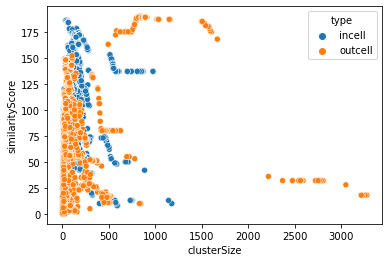

In [327]:

sns.scatterplot(data=df,x='clusterSize',y='similarityScore',hue='type');

#table = pd.crosstab(df.clusterSize,df.type)
#table.div(table.sum(1).astype(float),axis=0).plot()

In [328]:
X = np.asarray(df[['clusterSize','similarityScore']]);
Y = np.asarray(df.type.cat.codes);
#X_new = X[:,0]*X[:,1]
#X = np.column_stack((X,X_new[:, None]))

In [329]:
# define min max scaler and transform
X =  MinMaxScaler().fit_transform(X)

#  Regression

In [369]:
if True:
    model = LogisticRegression(C=1e2,verbose=True);# class_weight={0:0,1:1}
    #logreg = Perceptron()
    model.fit(X, Y);
    
else:
    model = LinearDiscriminantAnalysis()
    model.fit(X, Y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


# Evaluate Classifier

In [370]:
model.predict(X)

array([1, 0, 1, ..., 0, 0, 1], dtype=int8)

In [371]:
np.sum(model.predict(X)==Y)/len(Y)

0.5173376774493833

In [372]:
model.score(X,Y)

0.5173376774493833

In [373]:
#x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
#y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

x_min, x_max = X[:, 0].min(), X[:, 0].max()
y_min, y_max = X[:, 1].min(), X[:, 1].max()

h = 0.01  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
#Z = model.predict(np.c_[xx.ravel(), yy.ravel(),xx.ravel()*yy.ravel()])
#Z = Z[:,0]
# Put the result into a color plot
Z = Z.reshape(xx.shape)

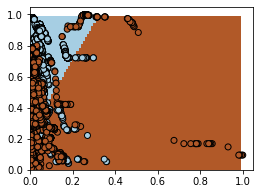

In [374]:
plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, Z,cmap=plt.cm.Paired)

## Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y,edgecolors='k', cmap=plt.cm.Paired)

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.551


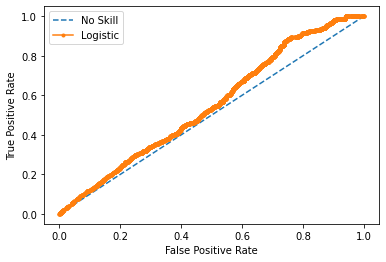

In [375]:
# generate a no skill prediction (majority class)
ns_probs = [1 for _ in range(len(Y))]
# predict probabilities
lr_probs = model.predict_proba(X)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(Y, ns_probs)
lr_auc = roc_auc_score(Y, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(Y, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(Y, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

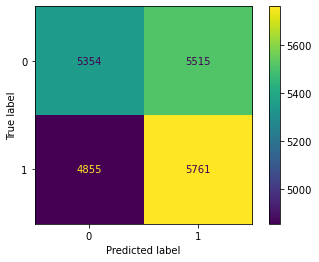

In [376]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = model.predict(X)
cm = confusion_matrix(Y, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

# Select region manually

In [439]:
def f1(beta):
    beta0,beta1 = beta[0],beta[1];
    
    Z = beta0 + beta1*X[:,0] - X[:,1];
    
    mark = (Z < 0);
    
    if(np.sum(mark)==0):
        return 0;
    else:
        return -np.sum(Y[mark])/np.sum(mark);

In [440]:
f1([0.2,0.2,0.2])

-0.47609465550547325

In [464]:
#f1([0.2,1.2,0.2])
f1([1,-1.2])

-0.9411764705882353

In [461]:
from scipy.optimize import minimize, rosen, rosen_der

In [467]:
res = minimize(f1, [1,-1.4],tol=1e-8);

In [468]:
res

      fun: -0.8093385214007782
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 3
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([ 1. , -1.4])

In [446]:
def f(x):   # The rosenbrock function
    return .5*(1 - x[0])**2 + (x[1] - x[0]**2)**2
minimize(f, [2, -1], method="CG")    

     fun: 1.6503729082243953e-11
     jac: array([-6.15347610e-06,  2.53804028e-07])
 message: 'Optimization terminated successfully.'
    nfev: 81
     nit: 13
    njev: 27
  status: 0
 success: True
       x: array([0.99999426, 0.99998863])

# Iris Dataset

In [91]:
iris = datasets.load_iris()
X = iris.data[:, :2]  # we only take the first two features.
Y = iris.target

# Create an instance of Logistic Regression Classifier and fit the data.
logreg = LogisticRegression(C=1e5)
logreg.fit(X, Y)

LogisticRegression(C=100000.0)

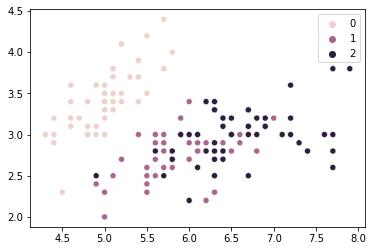

In [94]:
sns.scatterplot(x=X[:,0],y=X[:,1],hue=Y)

In [99]:
logreg.coef_

array([[-36.45485436,  30.74790469],
       [ 17.27627106, -15.57630142],
       [ 19.1785833 , -15.17160327]])

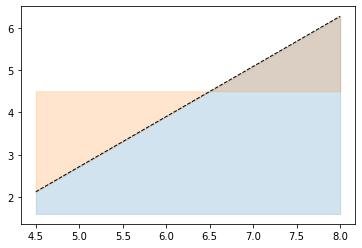

In [108]:
b = logreg.intercept_[0]
w1, w2 = logreg.coef_[0]

c = -b/w2
m = -w1/w2

# Plot the data and the classification with the decision boundary.
xmin, xmax = 4.5,8
ymin, ymax = 1.6,4.5
xd = np.array([xmin, xmax])
yd = m*xd + c
plt.plot(xd, yd, 'k', lw=1, ls='--')
plt.fill_between(xd, yd, ymin, color='tab:blue', alpha=0.2)
plt.fill_between(xd, yd, ymax, color='tab:orange', alpha=0.2)

In [103]:
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)

In [105]:
xx

array([[3.8 , 3.82, 3.84, ..., 8.36, 8.38, 8.4 ],
       [3.8 , 3.82, 3.84, ..., 8.36, 8.38, 8.4 ],
       [3.8 , 3.82, 3.84, ..., 8.36, 8.38, 8.4 ],
       ...,
       [3.8 , 3.82, 3.84, ..., 8.36, 8.38, 8.4 ],
       [3.8 , 3.82, 3.84, ..., 8.36, 8.38, 8.4 ],
       [3.8 , 3.82, 3.84, ..., 8.36, 8.38, 8.4 ]])

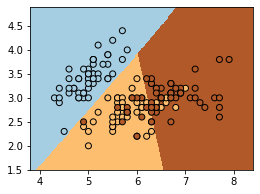

In [107]:
plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y,edgecolors='k', cmap=plt.cm.Paired)

In [68]:
logreg.get_params()

{'C': 100000.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [69]:
xx = np.linspace(0, 1500, 100)
yy = np.linspace(0,200, 100).T
xx, yy = np.meshgrid(xx, yy)
Xfull = np.c_[xx.ravel(), yy.ravel()]

In [79]:
yy.ravel()

array([  0.,   0.,   0., ..., 200., 200., 200.])

In [71]:
probas = logreg.predict_proba(Xfull)

/Users/andreas/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:2142: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if v not in values:


ValueError: array([[0.43462277, 0.56537723],
       [0.4318417 , 0.5681583 ],
       [0.42906492, 0.57093508],
       ...,
       [0.43761566, 0.56238434],
       [0.43483016, 0.56516984],
       [0.43204878, 0.56795122]]) is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'

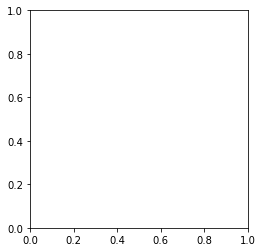

In [73]:
plt.imshow(Xfull,probas)

ValueError: not enough values to unpack (expected 2, got 1)

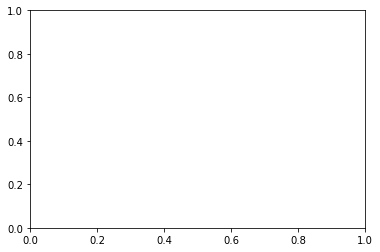

In [80]:
plt.pcolormesh(xx.ravel(), yy.ravel(), probas[:,0])